# After naive keras kernel. See https://www.kaggle.com/bguberfain/naive-keras

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split

In [14]:
input_folder = join('..', 'input')

df_mask = pd.read_csv('../data/train_masks.csv')
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()
imgs_idx = list(range(1, 17))

In [ ]:
load_img = lambda im, idx: imread('../data/raw/train/{}_{:02d}.jpg'.format(im, idx))
load_mask = lambda im, idx: imread('../data/raw/train_masks/{}_{:02d}_mask.gif'.format(im, idx))

resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [ ]:
num_train = 32  # len(ids_train)

# Load data for position id=1
X = np.empty((num_train, 320, 480, 12), dtype=np.float32)
y = np.empty((num_train, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        del imgs_id # Free memory
        bar.update()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Concat overall y info to X
# This is important as the kernels of CNN used below has no information of its location
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_min = y_train.min(axis=0)

y_features = np.concatenate([y_train_mean, y_train_std, y_train_min], axis=2)

X_train[:, ..., -3:] = y_features
X_val[:, ..., -3:] = y_features

In [ ]:
# Normalize input and output
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

In [ ]:
# Create simple model
from keras.layers import Conv2D
from keras.models import Sequential
import keras.backend as K

model = Sequential()
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 12) ) )
model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )


In [ ]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])

In [ ]:
X_train

In [41]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=5, verbose=0)

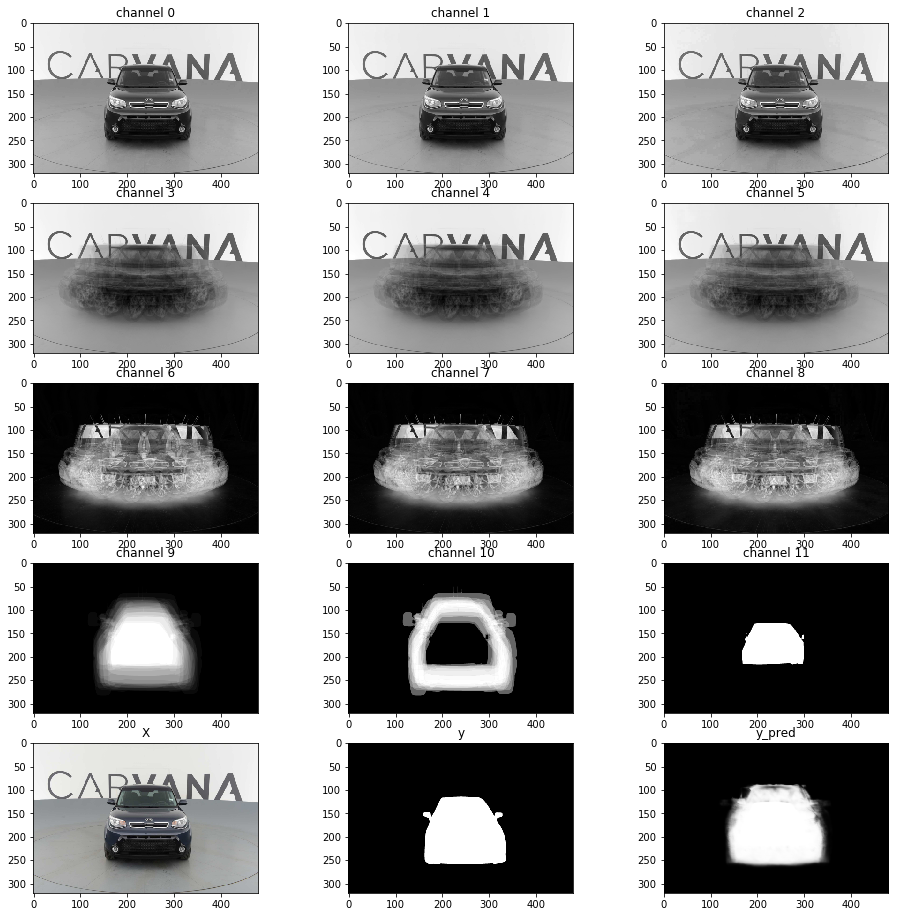

In [42]:
idx = 0
x = X_val[idx]

fig, ax = plt.subplots(5,3, figsize=(16, 16))
ax = ax.ravel()

cmaps = ['Reds', 'Greens', 'Blues']
for i in range(x.shape[-1]):
    ax[i].imshow(x[...,i], cmap='gray') #cmaps[i%3])
    ax[i].set_title('channel {}'.format(i))

ax[-3].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255.)
ax[-3].set_title('X')

ax[-2].imshow(y_train[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

In [46]:
y.shape

(32, 320, 480, 1)

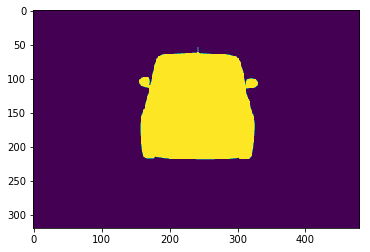

In [48]:
plt.imshow(y[1,:,:,0])

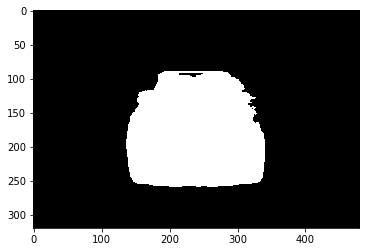

In [43]:
%matplotlib inline
plt.imshow(y_pred > 0.5, cmap='gray')

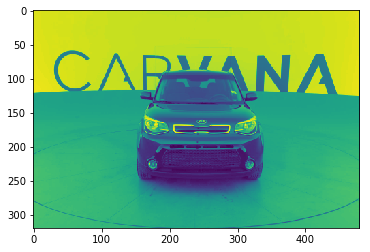

In [44]:
plt.imshow(x[:,:,1])

In [35]:
y_pred.shape


(320, 480)

## Understanding Dice coefficient

In [52]:
# see https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i

In [72]:
# segmentation
seg = np.zeros((100,100), dtype='int')
seg[30:70,30:70] = 1

# ground truth
gt = np.zeros((100,100), dtype='int')
gt[0:10, 0:10] = 1


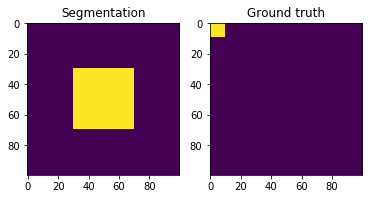

In [73]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.imshow(seg)
ax1.imshow(gt)
ax0.set_title('Segmentation')
ax1.set_title('Ground truth')

In [74]:
dice = 2*np.sum(seg[gt==1]) / (np.sum(seg) + np.sum(gt))

In [75]:
dice

0.0

makes perfect sense

# Run-length encoding

In [7]:
# Import libraries
import numpy as np # linear algebra
from PIL import Image

# Fast run length encoding
def rle (img):
    flat_img = img.flatten()
    flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    
    return starts_ix, lengths

In [8]:
mask = np.array(Image.open('../data/raw/train_masks/00087a6bd4dc_01_mask.gif'), dtype=np.uint8)

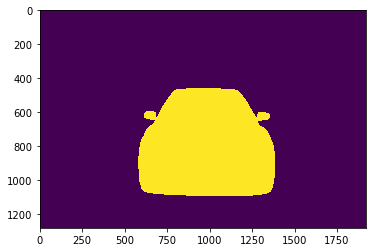

In [92]:
plt.imshow(mask)

In [25]:
mask_rle = rle(mask)

In [26]:
list1 = mask_rle[0]
list2 = mask_rle[1]

In [28]:
result = [None]*(len(list1)+len(list2))
result[::2] = list1
result[1::2] = list2

result = [str(e) for e in result]

#' '.join(result)

In [9]:
import sys
sys.path.append('../src')

import postprocessing as post

In [10]:
post.rle(mask)

(array([ 879386,  881253,  883140,  885009,  885032,  886923,  888839,
         890754,  892670,  894587,  896503,  898420,  900336,  902253,
         904170,  906086,  908003,  909920,  911837,  913754,  915671,
         917588,  919505,  921422,  923339,  925256,  927173,  929090,
         931007,  932925,  934842,  936759,  938676,  940593,  942510,
         944428,  946345,  948262,  950179,  952097,  954014,  955931,
         957848,  959766,  961683,  963600,  965517,  967435,  969352,
         971269,  973186,  975104,  977021,  978938,  980855,  982773,
         984690,  986607,  988525,  990442,  992359,  994277,  996194,
         998111, 1000028, 1001946, 1003863, 1005780, 1007698, 1009615,
        1011532, 1013450, 1015367, 1017284, 1019202, 1021119, 1023036,
        1024954, 1026871, 1028788, 1030706, 1032623, 1034540, 1036458,
        1038375, 1040292, 1042210, 1044127, 1046044, 1047962, 1049879,
        1051796, 1053714, 1055631, 1057549, 1059466, 1061383, 1063301,
      